## Overview

This notebook explores optimization through visualization.

It relies heavily on the Sympy library:
https://docs.sympy.org/latest/
    
As well as various methods for generating contour plots of level sets:

https://stackoverflow.com/questions/33105414/level-sets-of-a-function-using-min

https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html
    
Examples are from:

Boyd and Vanderberghe's text on convex optimization: https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf

Elad Hazan's text on online convex optimization: https://ocobook.cs.princeton.edu/


In [1]:
import itertools

import matplotlib.pyplot as plt
%pylab inline

from mpmath import e
import numpy as np

import sympy as sp

from sympy import diff, symbols, Matrix
from sympy.plotting import plot3d


x, y = symbols('x y')
sp.init_printing()

Populating the interactive namespace from numpy and matplotlib


## Setting Functions and Ranges

The below boxes allow for setup of the function to be optimized / visualized.
Quadratic and non-quadratic examples from B&V Chapter 9 are included.

In [2]:
# Quadratic example
# Suggest range of -10 to 10
gamma = 10
quadratic = (x**2 + gamma * y **2)

# Non-quadratic Boyd example
# Suggest range of -1 to 1
boyd_example = e**(x + 3*y - .1) + e**(x - 3*y - .1) + e**(-x - .1)

# Set the function you want to visualize
f = boyd_example

# Set the range to use across plots etc-- this will be used to generate a square mesh from -/+
range_scale_factor = 10

## Function Evaluation

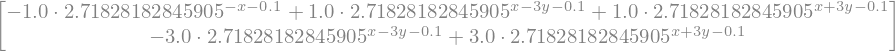

In [3]:
gradient = sp.Matrix([diff(f, x), diff(f, y)])
gradient

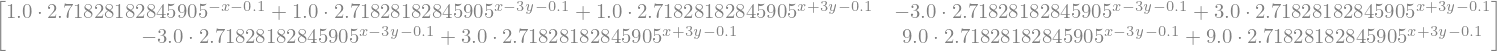

In [4]:
hessian = gradient.jacobian([x, y])
hessian

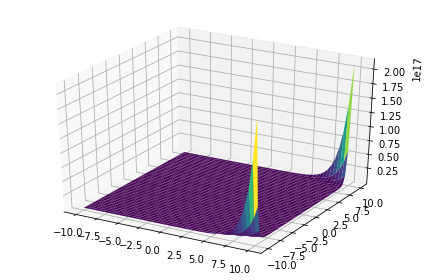

In [5]:
# A set of percentiles for contour plots
percentiles_to_plot = [-1, -.75, -.5, -.3, -.25, -.2, -.15, -.1, -.075, -.05, -.025]
full_range = percentiles_to_plot + [0] + [-e for e in reversed(percentiles_to_plot)]

x_min = y_min = min(full_range) * range_scale_factor
x_max = y_max = max(full_range) * range_scale_factor

plt.figure(figsize=(10,10))
plot3d(f, (x, x_min, x_max), (y, y_min, y_max))

## Evaluating Functions and Norms

The below functions generate a meshgrid of points and run an evaluation at that point. These are used to generate the contour / level plots, as well as visualizations of different norm balls.

In [6]:
def mesh_eval_2D(f, x_range, y_range, norm=None, print_progress=False):
    """Take a function and evaluate it on the x-y range provided."""
    
    x_mesh,y_mesh = np.meshgrid(x_range, y_range)

    f_mesh = []
    for i in range(len(x_range)):
        
        if (print_progress and i%5 == 0):
            print("Eval {} of {} of outer loop.".format(i, len(x_range))) 
        
        interior_array = []
        for j in range(len(y_range)):
            
            x_val = x_mesh[i,j]
            y_val = y_mesh[i,j]
            
            # Option to renormalize coordinates as per passed-in matrix
            if norm:
                local_matrix = norm.subs({x:x_val, y:y_val})
                normed_xy = local_matrix**(.5) * Matrix([x_val, y_val])
                x_val = normed_xy[0]
                y_val = normed_xy[1]
            
            f_output = f.subs({x:x_val, y:y_val})

            interior_array.append(f_output)

        f_mesh.append(interior_array)

    return x_mesh, y_mesh, f_mesh


def norm_mesh_2D(x_range, y_range, order=None, matrix=None, print_progress=False):
    """Loop over all points in the mesh and calculate their normed distance."""
    
    x_mesh,y_mesh = np.meshgrid(x_range, y_range)

    norm_mesh = []
    for i in range(len(x_range)):
        
        if (print_progress and i%5 == 0):
            print("Iteration {} of {}.".format(i, len(x_range)))
        
        interior_array = []
        for j in range(len(y_range)):
            
            vector = Matrix([x_mesh[i,j], y_mesh[i,j]])
            if matrix:
                norm_output = (matrix**(.5) * vector).norm()
                # Alternatively:
                # norm_output = math.sqrt((vector.T * matrix * vector)[0])
            else:
                norm_output = vector.norm(ord=order)

            interior_array.append(norm_output)

        norm_mesh.append(interior_array)

    return x_mesh, y_mesh, norm_mesh


def get_contour_levels(value_mesh):
    """Retrieve contour levels at a pre-specified percentile range for plotting."""
    
    percentiles_to_plot = [.5, 1, 3] + list(range(5, 100, 5)) + [99]

    all_values = list(itertools.chain.from_iterable(value_mesh))
    series = np.array(all_values).astype('float')
    values = np.percentile(series, percentiles_to_plot)
    
    return values

### Plot basic level sets of function

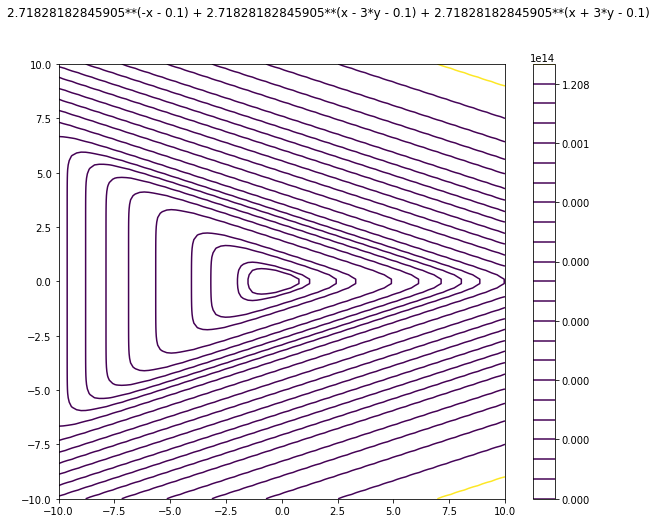

In [7]:
x_range = np.linspace(x_min, x_max, num=100)
y_range = np.linspace(y_min, y_max,num=100)

x_mesh, y_mesh, f_mesh = mesh_eval_2D(f, x_range, y_range)

plt.ion()
plt.figure(figsize=(10,8))

c = plt.contour(x_mesh, y_mesh,f_mesh, get_contour_levels(f_mesh))
plt.suptitle("{}".format(f))
plt.colorbar()
plt.show() 

### Re-normalize level sets using a matrix

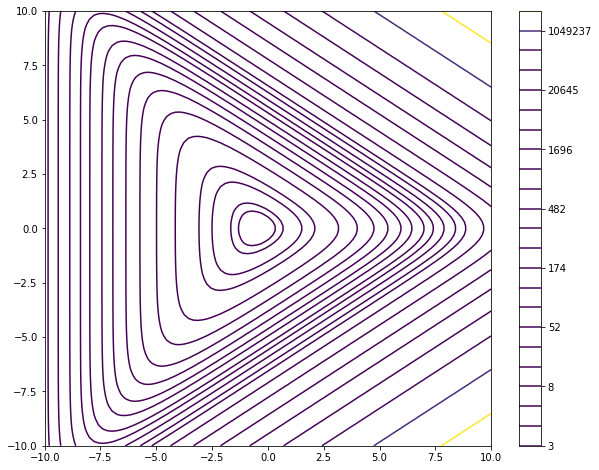

In [11]:
# Using "good" quadratic norm from B&V
norm_p1 = Matrix([[2, 0], [0, 8]])

x_range = np.linspace(x_min, x_max, num=100)
y_range = np.linspace(y_min, y_max, num=100)
x_mesh, y_mesh, p1_mesh = mesh_eval_2D(f, x_range, y_range, norm=norm_p1.inv())

plt.ion()
plt.figure(figsize=(10,8))
c = plt.contour(x_mesh, y_mesh, p1_mesh, get_contour_levels(p1_mesh))
plt.colorbar()
plt.show() 

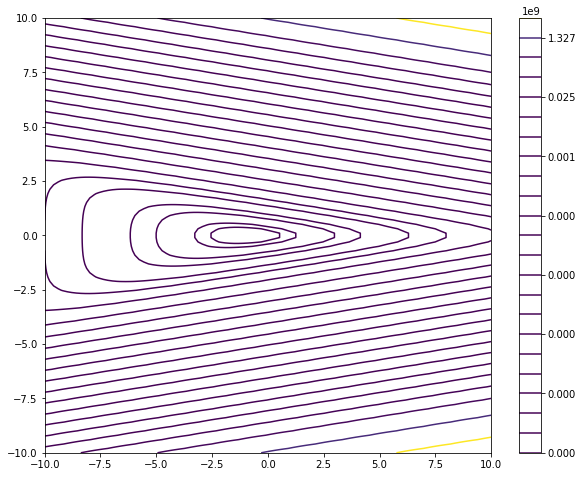

In [12]:
# Using "bad" quadratic norm
norm_p2 = Matrix([[8, 0], [0, 2]])
x_mesh, y_mesh, p2_mesh = mesh_eval_2D(f, x_range, y_range, norm=norm_p2.inv())


plt.ion()
plt.figure(figsize=(10, 8))
c = plt.contour(x_mesh, y_mesh, p2_mesh, get_contour_levels(p2_mesh))
plt.colorbar()
plt.show() 

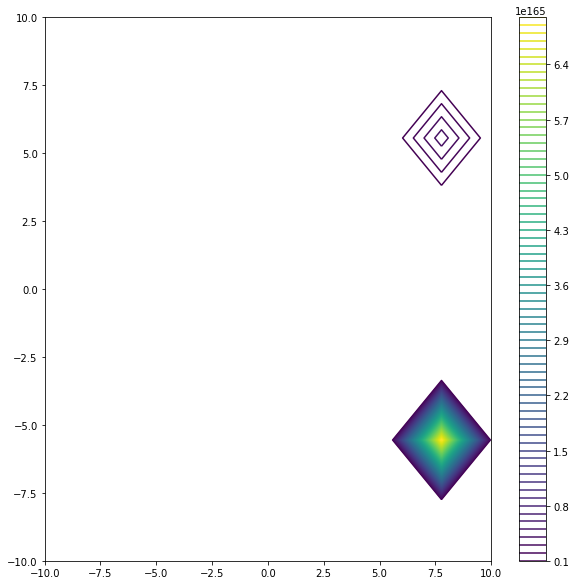

In [18]:
# Using Hessian quadratic norm
x_range = np.linspace(x_min, x_max, num=10)
y_range = np.linspace(y_min, y_max, num=10)

x_mesh, y_mesh, hessian_mesh = mesh_eval_2D(f, x_range, y_range, norm=hessian.inv())

plt.ion()
plt.figure(figsize=(10,10))
c = plt.contour(x_mesh, y_mesh, hessian_mesh, 80)
plt.colorbar()
plt.show() 

## Optimization Algorithms

In [19]:
def vanilla_gradient_descent(f, start_x, start_y, steps, eta=1):
    
    gradient = sp.Matrix([diff(f, x), diff(f, y)])
    x_t = start_x
    y_t = start_y
    
    optimization_sequence = []
    for i in range(0, steps):
        
        current_func_output = f.subs({x:x_t, y:y_t})
        local_gradient = -gradient.subs({x:x_t, y:y_t})
        
        # Cap step length at 1
        if local_gradient.norm() > 1:
            local_gradient = local_gradient.normalized()
        
        optimization_sequence.append({"i": i,
                                      "x_t": x_t,
                                      "y_t": y_t,
                                      "grad_t": local_gradient,
                                      "f_t": current_func_output
                                     })
        
        x_t = x_t + eta * local_gradient[0]
        y_t = y_t + eta* local_gradient[1]

    return optimization_sequence

In [20]:
def backtracking_line_search(f, start_x, start_y, steps, alpha=.2, beta=.5):
    
    gradient = sp.Matrix([diff(f, x), diff(f, y)])
    x_t = start_x
    y_t = start_y
    
    optimization_sequence = []
    for i in range(0, steps):
        
        current_func_output = f.subs({x:x_t, y:y_t})
        step_size = 1
        
        local_gradient = -gradient.subs({x:x_t, y:y_t})
        
        proposed_step = step_size * local_gradient
        actual_output = f.subs({x: x_t + proposed_step[0],
                             y: y_t + proposed_step[1]
                            })
        projection = current_func_output + (alpha * step_size * local_gradient.T * proposed_step)[0]
        
        while actual_output > projection:
            
            step_size *= beta
            proposed_step = step_size * local_gradient

            actual_output = f.subs({x: x_t + proposed_step[0],
                                    y: y_t + proposed_step[1]
                                   })
            projection = current_func_output + (alpha * step_size * local_gradient.T * proposed_step)[0]
        
        
        optimization_sequence.append({"i": i,
                                      "x_t": x_t,
                                      "y_t": y_t,
                                      "grad_t": local_gradient,
                                      "unit_grad_t": local_gradient.normalized(),
                                      "backtracking_step": proposed_step,
                                      "f_t": current_func_output
                                     })
        
        x_t = x_t + proposed_step[0]
        y_t = y_t + proposed_step[1]

    return optimization_sequence

In [21]:
def online_newtons_step(f, start_x, start_y, steps, epsilon):
        
    x_t = start_x
    y_t = start_y
    A = sp.Matrix.eye(2) * epsilon

    gradient = sp.Matrix([diff(f, x), diff(f, y)])
    
    optimization_sequence = []
    for i in range(0, steps):

        # Note that I'm normalizing the gradient here for stability.
        # Ideally you would calibrate / use parameters gamma / epsilon to control
        # matrix initialization and step size appropriately instead
        current_func_output = f.subs({x:x_t, y:y_t})
        local_gradient = gradient.subs({x:x_t, y:y_t}).normalized()
                        
        rank_one_matrix = local_gradient * local_gradient.T
        A += rank_one_matrix
        
        normalized_gradient = A.inv() * local_gradient
        
        optimization_sequence.append({"i": i,
                              "x_t": x_t,
                              "y_t": y_t,
                              "grad_t": local_gradient,
                              "normalized_gradient": normalized_gradient,
                              "f_t": current_func_output,
                              "rank_one_matrix": rank_one_matrix,
                              "a_t": A
                             })
        
        x_t = x_t - normalized_gradient[0]
        y_t = y_t - normalized_gradient[1]

    return optimization_sequence

## Running / Visualizing Optimization Functions

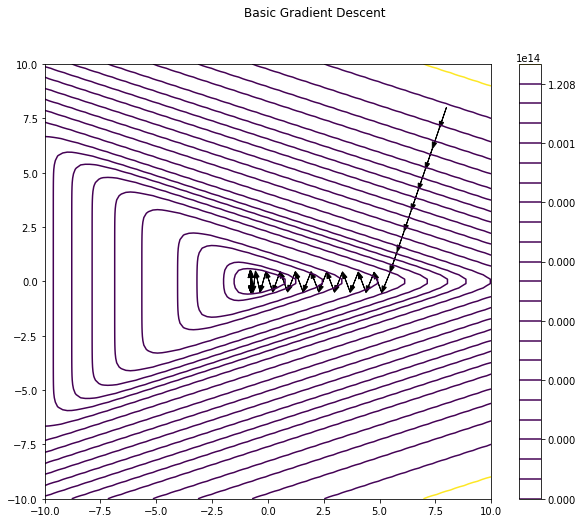

In [23]:
x_range = np.linspace(x_min, x_max, num=100)
y_range = np.linspace(y_min, y_max,num=100)

# Set up plot
plt.ion()
plt.figure(figsize=(10,8))

# Generate and plot mesh
x_mesh, y_mesh, f_mesh = mesh_eval_2D(f, x_range, y_range)
c = plt.contour(x_mesh, y_mesh, f_mesh, get_contour_levels(f_mesh))
plt.colorbar()

# Generate optimization trajectory and plot
optimization_trajectory = vanilla_gradient_descent(f, 8, 8, 50)
for point in optimization_trajectory:
    
    plt.arrow(point["x_t"], point["y_t"], 
              float(point["grad_t"][0]), float(point["grad_t"][1]),
              head_width=0.2, head_length=0.3, fc='k', ec='k', length_includes_head=True)

plt.suptitle("Basic Gradient Descent")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show() 

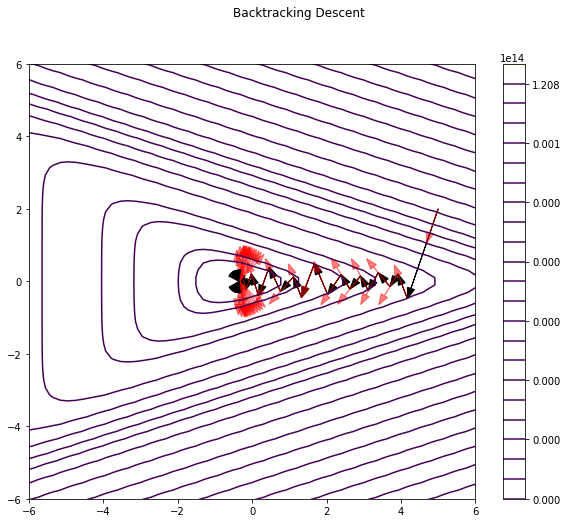

In [24]:
x_range = np.linspace(x_min, x_max, num=100)
y_range = np.linspace(y_min, y_max,num=100)

plt.ion()
plt.figure(figsize=(10,8))

x_mesh, y_mesh, f_mesh = mesh_eval_2D(f, x_range, y_range)
c = plt.contour(x_mesh, y_mesh,f_mesh, get_contour_levels(f_mesh))

plt.colorbar()

optimization_trajectory = backtracking_line_search(f, 5, 2, 50)
for point in optimization_trajectory:
    
    plt.arrow(point["x_t"], point["y_t"], 
              float(point["backtracking_step"][0]), float(point["backtracking_step"][1]),
              head_width=0.2, head_length=0.3, fc='k', ec='k', length_includes_head=True)
    
    plt.arrow(point["x_t"], point["y_t"], 
          float(point["unit_grad_t"][0]), float(point["unit_grad_t"][1]),
          head_width=0.2, head_length=0.3, fc='r', ec='r', length_includes_head=True, alpha=.5)

plt.suptitle("Backtracking Descent")
plt.xlim(-6, 6)
plt.ylim(-6, 6)

plt.show() 

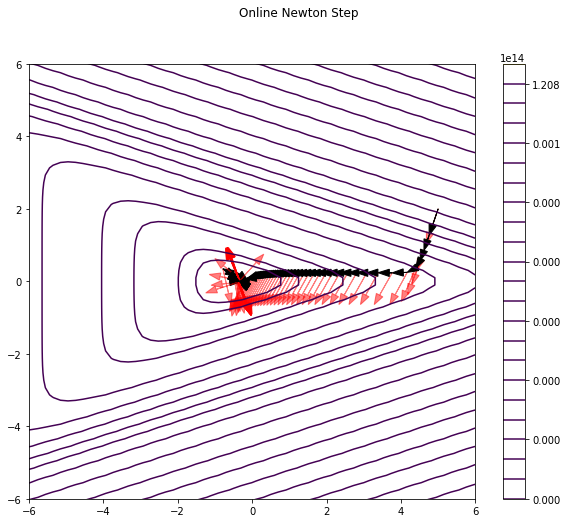

In [25]:
x_range = np.linspace(x_min, x_max, num=100)
y_range = np.linspace(y_min, y_max, num=100)

plt.ion()
plt.figure(figsize=(10,8))

x_mesh, y_mesh, f_mesh = mesh_eval_2D(f, x_range, y_range)
c = plt.contour(x_mesh, y_mesh,f_mesh, get_contour_levels(f_mesh))
plt.colorbar()

# Example parameters: 5, 2, 100 steps, epsilon = .3
optimization_trajectory = online_newtons_step(f, 5, 2, 100, .3)
for point in optimization_trajectory:
    
    plt.arrow(point["x_t"], point["y_t"], 
              -float(point["grad_t"][0]), -float(point["grad_t"][1]),
              head_width=0.2, head_length=0.3, fc='r', ec='r', alpha=.5, length_includes_head=True)

    plt.arrow(point["x_t"], point["y_t"], 
              -float(point["normalized_gradient"][0]), -float(point["normalized_gradient"][1]),
              head_width=0.2, head_length=0.3, fc='k', ec='k', length_includes_head=True)

plt.suptitle("Online Newton Step")
plt.xlim(-6, 6)
plt.ylim(-6, 6)

plt.show() 

## Exploring ONS Accumulation Matrices

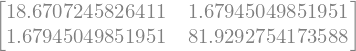

In [26]:
ons_example_trajectory = online_newtons_step(f, 5, 2, 100, .3)

ons_final_matrix = ons_example_trajectory[-1]["a_t"]
ons_final_matrix

# Can check intermediate matrixes with other indexes here, i.e.
# ons_fifth_matrix = ons_example_trajectory[4]["a_t"]

In [27]:
x_range = np.linspace(x_min, x_max, num=100)
y_range = np.linspace(y_min, y_max, num=100)

x_mesh, y_mesh, ons_derived_mesh = mesh_eval_2D(f, x_range, y_range, norm=ons_final_matrix.inv(), print_progress=True)

Eval 0 of 100 of outer loop.
Eval 5 of 100 of outer loop.
Eval 10 of 100 of outer loop.
Eval 15 of 100 of outer loop.
Eval 20 of 100 of outer loop.
Eval 25 of 100 of outer loop.
Eval 30 of 100 of outer loop.
Eval 35 of 100 of outer loop.
Eval 40 of 100 of outer loop.
Eval 45 of 100 of outer loop.
Eval 50 of 100 of outer loop.
Eval 55 of 100 of outer loop.
Eval 60 of 100 of outer loop.
Eval 65 of 100 of outer loop.
Eval 70 of 100 of outer loop.
Eval 75 of 100 of outer loop.
Eval 80 of 100 of outer loop.
Eval 85 of 100 of outer loop.
Eval 90 of 100 of outer loop.
Eval 95 of 100 of outer loop.


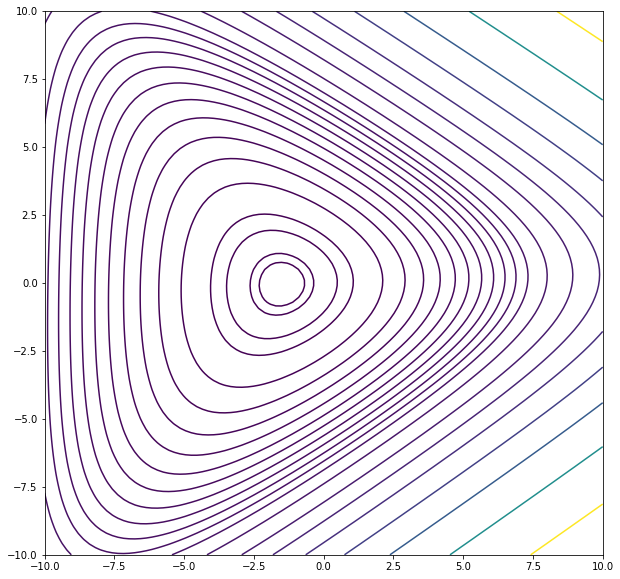

In [28]:
plt.ion()
plt.figure(figsize=(10,10))
c = plt.contour(x_mesh, y_mesh, ons_derived_mesh, get_contour_levels(ons_derived_mesh))
plt.show() 

## Plotting Norm Balls

In [29]:
euclidean_norm = Matrix.eye(2)
quadratic_norm = Matrix([[2, 0], [0, 8]])
hessian_of_nonquadratic = hessian.subs({x: -.3466, y:0})

strang_example_norm = Matrix([[3,0], [0,2]])

basic_stretching_matrix = Matrix([[1,0], [0,2]])

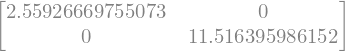

In [30]:
norm_matrix = hessian_of_nonquadratic

norm_matrix

In [31]:
vector = Matrix([1, 1])
vector

In [32]:
print("Length of vector under matrix: {}".format(math.sqrt((vector.T * norm_matrix * vector)[0])))

Length of vector under matrix: 3.7517546140043265


### Basic: Plot euclidean and quadratic norm balls

Iteration 0 of 100.
Iteration 5 of 100.
Iteration 10 of 100.
Iteration 15 of 100.
Iteration 20 of 100.
Iteration 25 of 100.
Iteration 30 of 100.
Iteration 35 of 100.
Iteration 40 of 100.
Iteration 45 of 100.
Iteration 50 of 100.
Iteration 55 of 100.
Iteration 60 of 100.
Iteration 65 of 100.
Iteration 70 of 100.
Iteration 75 of 100.
Iteration 80 of 100.
Iteration 85 of 100.
Iteration 90 of 100.
Iteration 95 of 100.


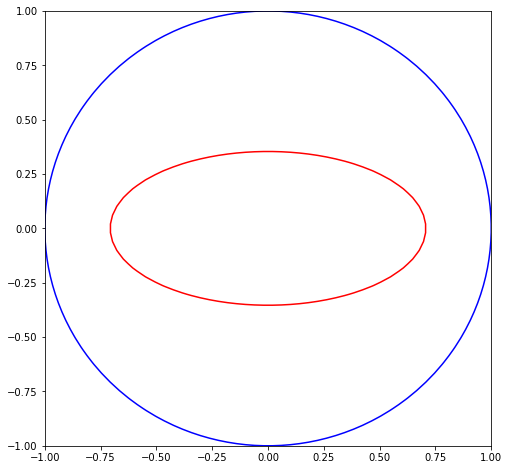

In [33]:
x_range = np.linspace(-2, 2, num=100)
y_range = np.linspace(-2, 2, num=100)
plt.figure(figsize=(8,8))

x_mesh, y_mesh, euclidean_norm_mesh = norm_mesh_2D(x_range, y_range)
c = plt.contour(x_mesh, y_mesh, euclidean_norm_mesh, [1], colors='b')

x_mesh, y_mesh, quadratic_norm_mesh = norm_mesh_2D(x_range, y_range, matrix=quadratic_norm, print_progress=True)
c = plt.contour(x_mesh, y_mesh, quadratic_norm_mesh, [1], colors='r')

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

### Plot Hessian, ONS, etc norms 

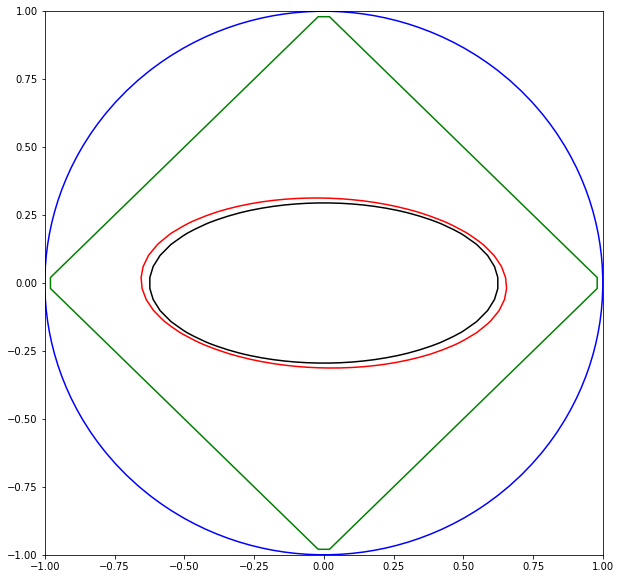

In [37]:
x_range = np.linspace(-2, 2, num=100)
y_range = np.linspace(-2, 2, num=100)

ons_plot_matrix = ons_final_matrix / 8

x_mesh, y_mesh, manhattan_norm_mesh = norm_mesh_2D(x_range, y_range, order=1)
x_mesh, y_mesh, hessian_norm = norm_mesh_2D(x_range, y_range, matrix=hessian_of_nonquadratic)
x_mesh, y_mesh, ons_norm = norm_mesh_2D(x_range, y_range, matrix=ons_plot_matrix)

plt.figure(figsize=(10,10))
c = plt.contour(x_mesh, y_mesh, euclidean_norm_mesh, [1], colors='b')
c = plt.contour(x_mesh, y_mesh, manhattan_norm_mesh, [1], colors='g')
c = plt.contour(x_mesh, y_mesh, hessian_norm, [1], colors='k')
c = plt.contour(x_mesh, y_mesh, ons_norm, [1], colors='r')

plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show() 